In [1]:
!pip install torch torchvision numpy Pillow matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

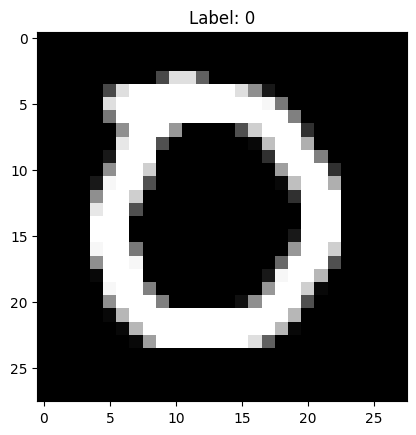

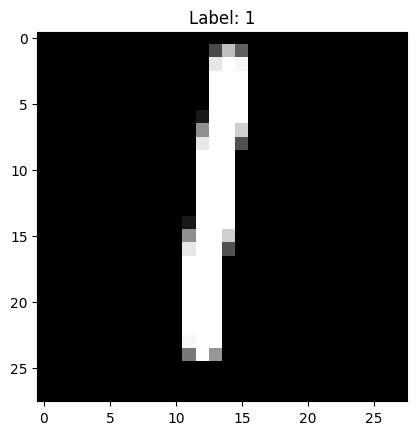

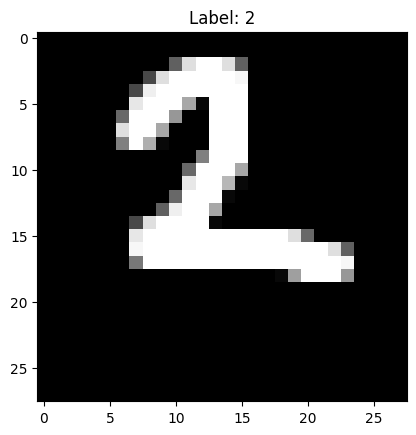

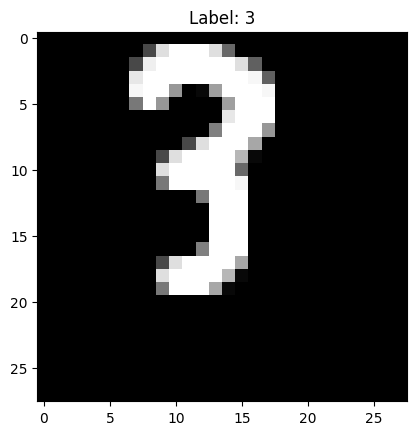

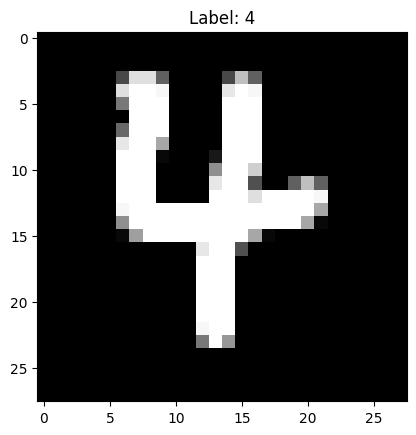

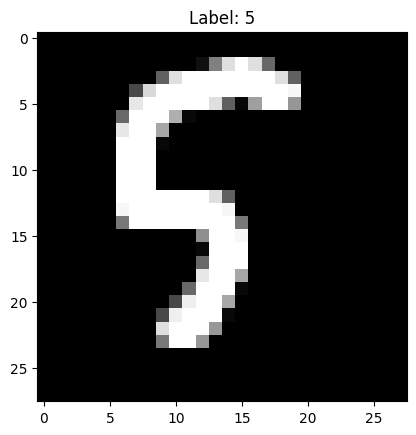

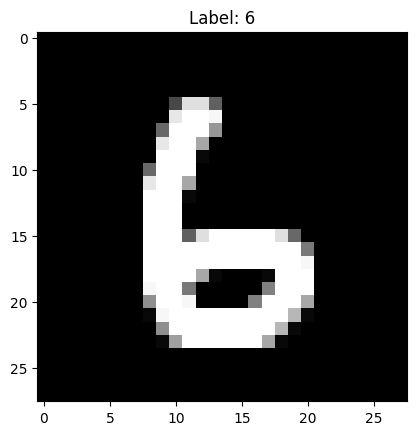

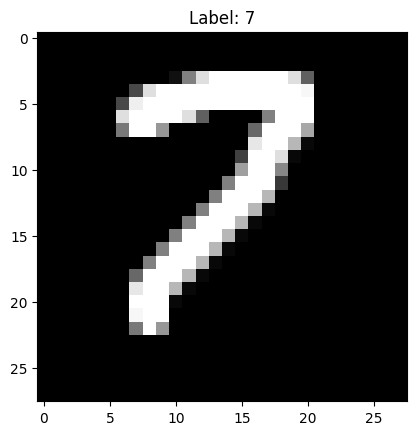

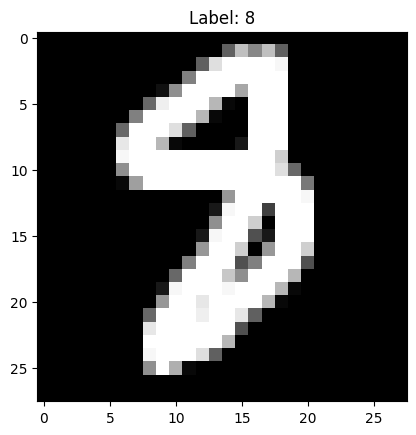

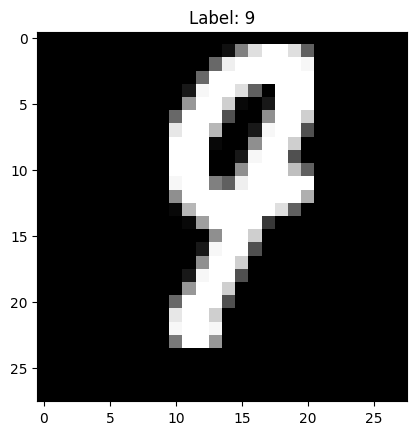

In [3]:
def load_images_and_preprocess(directory):
    """
    Helper function to load and preprocess handwritten images and their labels.

    Args:
        directory (str): Path to the directory containing image files.

    Returns:
        images (torch.Tensor): Tensor of image data (num_images, 1, 28, 28).
        labels (torch.Tensor): Tensor of labels corresponding to the images.
    """
    images = []
    labels = []

    # Define a PyTorch transformation to normalize to [-1, 1]
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),  # Converts to tensor and scales [0, 255] to [0, 1]
        transforms.Normalize(mean=0.5, std=0.5)  # Normalizes [0, 1] to [-1, 1]
    ])

    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            # Parse the label from the filename (e.g., '0-3-1.png' -> label = 0)
            label = int(filename.split('-')[0])
            
            # Load the image
            image_path = os.path.join(directory, filename)
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            
            # Resize to 28x28 if necessary (assuming MNIST compatibility)
            image = image.resize((28, 28))
            
            # Apply transformations
            image_tensor = transform(image)
            
            # Append to list
            images.append(image_tensor)
            labels.append(label)
    
    # Stack tensors into a single tensor
    images = torch.stack(images)  # Shape: (num_images, 1, 28, 28)
    labels = torch.tensor(labels, dtype=torch.long)  # Shape: (num_images,)
    
    return images, labels

if __name__ == "__main__":
    # Directory containing handwritten images
    directory_path = "./digits".strip()
    
    try:
        # Load and preprocess images and labels
        images, labels = load_images_and_preprocess(directory_path)
        
        displayed_digits = set()

        # Check: Print labels 0-9
        for i in range(len(labels)):
            label = labels[i].item()
            if label not in displayed_digits:
                plt.imshow(images[i].squeeze(), cmap='gray')  
                plt.title(f"Label: {label}")
                plt.axis('on')
                plt.show()

                # keep track of displayed digits
                displayed_digits.add(label)
            
            # break when we've iterated through labels 0 to 9 
            if len(displayed_digits) == 10:
                break

    except Exception as e:
        print(f"Error: {e}")


In [4]:
class HandwrittenDigitsDataset(torch.utils.data.Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.image_files = [f for f in os.listdir(directory) if f.endswith(".png")]
        self.transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize(mean=0.5, std=0.5)
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        file_name = self.image_files[idx]
        label = int(file_name.split('-')[0])
        image_path = os.path.join(self.directory, file_name)
        image = Image.open(image_path).convert('L')
        image = self.transform(image)
        return image, label

# Create dataset and dataloader
dataset = HandwrittenDigitsDataset(directory_path)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def load_mnist_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Load MNIST dataset
train_loader, test_loader = load_mnist_data(batch_size=64)

Epoch [1/5], Step [100/938], Loss: 0.3662
Epoch [1/5], Step [200/938], Loss: 0.2824
Epoch [1/5], Step [300/938], Loss: 0.3251
Epoch [1/5], Step [400/938], Loss: 0.3010
Epoch [1/5], Step [500/938], Loss: 0.1870
Epoch [1/5], Step [600/938], Loss: 0.1658
Epoch [1/5], Step [700/938], Loss: 0.4521
Epoch [1/5], Step [800/938], Loss: 0.1736
Epoch [1/5], Step [900/938], Loss: 0.2026
Epoch [2/5], Step [100/938], Loss: 0.1303
Epoch [2/5], Step [200/938], Loss: 0.1305
Epoch [2/5], Step [300/938], Loss: 0.3765
Epoch [2/5], Step [400/938], Loss: 0.1837
Epoch [2/5], Step [500/938], Loss: 0.1499
Epoch [2/5], Step [600/938], Loss: 0.0955
Epoch [2/5], Step [700/938], Loss: 0.0471
Epoch [2/5], Step [800/938], Loss: 0.0804
Epoch [2/5], Step [900/938], Loss: 0.1249
Epoch [3/5], Step [100/938], Loss: 0.0574
Epoch [3/5], Step [200/938], Loss: 0.1579
Epoch [3/5], Step [300/938], Loss: 0.1790
Epoch [3/5], Step [400/938], Loss: 0.0482
Epoch [3/5], Step [500/938], Loss: 0.2224
Epoch [3/5], Step [600/938], Loss:

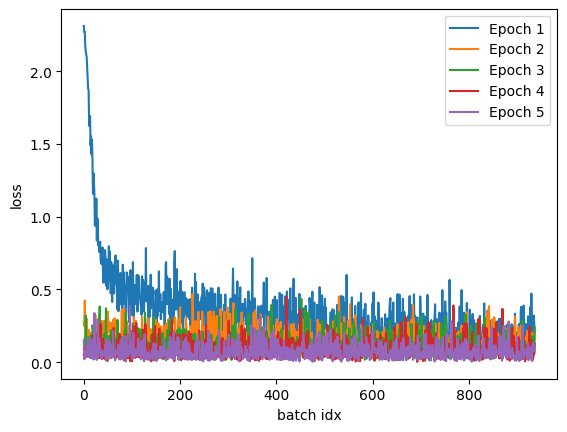

In [7]:
def train(model, device, train_loader, optimizer, criterion, epochs=5):
    model.train()
    plt.figure() 
    
    for epoch in range(epochs):
        batch_losses = [] 
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_losses.append(loss.item())  # Store the loss for plotting

            # Printing progress every 100 steps
            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Plotting the loss per batch for the current epoch on the same graph
        plt.plot(batch_losses, label=f'Epoch {epoch + 1}')

    # Finalizing the plot after all epochs are done
    plt.xlabel('batch idx')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

# Initialize model, criterion, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, device, train_loader, optimizer, criterion, epochs=5)

Test Accuracy: 97.23%
Avg Test Loss: 0.0897


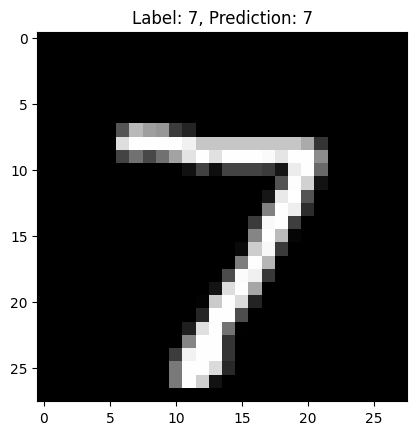

In [8]:
def test(model, device, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    example_image = None
    example_label = None
    example_prediction = None

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # storing first example
            if batch_idx == 0:
                example_image = images[0].cpu().squeeze()  
                example_label = labels[0].item()  
                example_prediction = predicted[0].item()  
    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Avg Test Loss: {avg_test_loss:.4f}")

    plt.imshow(example_image, cmap='gray')
    plt.title(f"Label: {example_label}, Prediction: {example_prediction}")
    plt.show()

# Test the model
test(model, device, test_loader, criterion)


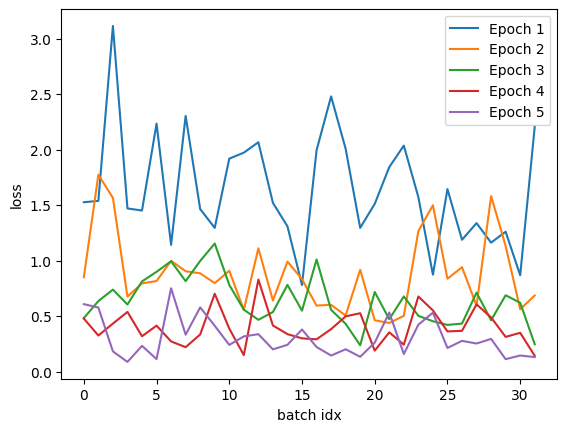

Test Accuracy: 94.99%
Avg Test Loss: 0.1812


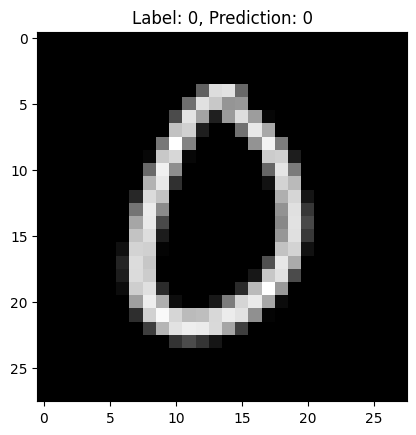

In [9]:
# Fine-tune the model using your own handwritten digits
fine_tune_loader = DataLoader(dataset, batch_size=16, shuffle=True)
train(model, device, fine_tune_loader, optimizer, criterion, epochs=5)
test(model, device, fine_tune_loader, criterion)